# EVC for nucleon-nucleon scattering.
Here we do tests of eigenvector continuation (EC) for the scattering phase shifts of NN scattering in s waves, based on the Minnesota potential ([NPA, 286, 53 (1977)](https://www.sciencedirect.com/science/article/abs/pii/0375947477900070)). However, the code works for general potentials, local/nonlocal, with or without coulomb, real/complex. Note that for complex potentials, the functions that need to be imported are different from those in this notebook; please look at the notebook for alpha-Pb scattering (`EVC_alpha_Pb.ipynb`).  

Figures for the Minnesota model from [arXiv:2007.03635](https://arxiv.org/abs/2007.03635), "Efficient emulators for scattering using eigenvector continuation" by R.J. Furnstahl, P.J. Millican, and Xilin Zhang are generated here.


#### Table of contents

1. [A code for testing the covex hull of  basis points](#convex_hull_code)
1. [Set up the output directory](#output_dir)
1. [Code for generating results](#main_code)
1. [Minnesota potential in s waves WITHOUT coulomb](#Main_calculations)
  1. [Set the global parameters and define NN potential](#global_para_setup) 
  1. [For 1S0 channel](#1S0_channel)
     1. [A test of scattering wave function from EC](#test_wf)
     1. [A test of scattering phase shifts from EC](#test_ps)
     1. [Test EC using a sample of test points in a 2-dim parameter space](#test_EC_2dim)
     1. [Test EC using a sample of test points in a 4-dim parameter space](#test_EC_4dim)
  1. [For 3S1 channel](#3S1_channel)
     1. [Test EC using a sample of test points in a 2-dim parameter space](#test_EC_2dim_3S1)
     1. [Test EC using a sample of test points in a 4-dim parameter space](#test_EC_4dim_3S1)
1. [Collect the results and make plots for both channels](#plots)     
  1. [For 1S0 channel](#plots_1S0)
  1. [For 3S1 channel](#plots_3S1)



In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
from scipy.integrate import simps
from scipy.optimize import linprog
import matplotlib.pyplot as plt

from pyDOE import lhs    # https://pythonhosted.org/pyDOE/
import pickle

# local imports
from Constants import * 
from two_body_pot import two_body_pot,  rmat_ini
from evc_two_body import EigenvectorContinuationScattering

## A code for testing the convex hull of  basis points. <a id="convex_hull_code"></a>
This checks within a parameter space whether a point is inside or outside the convex hull of a given set of basis points.

In [2]:
def in_hull(points, x):
    '''points are basis points that define the convex hull,
    while x is the pointed to be tested.
    '''
    n_points = len(points)
    n_dim = len(x)
    c = np.zeros(n_points)
    A = np.r_[points.T,np.ones((1,n_points))]
    b = np.r_[x, np.ones(1)]
    lp = linprog(c, A_eq=A, b_eq=b)
    return lp.success

### Test this code
n_points = 10000
n_dim = 10
Z = np.random.rand(n_points,n_dim)
x = np.random.rand(n_dim)
print(in_hull(Z, x))

False


## Set up the ouput directory <a id="output_dir"></a>
Set up a dictionary to save the calcuation results. The pkl file will be saved in the output directory.

In [3]:
outdir='./Notebook_output/NN_Minnesota/'
res_dict={}

## Code for generating results <a id="main_code"></a>

    In the following function, we compute and collect all the results needed for comparing EVC with direct calculations. We loop over the list potential-basis. The inputs are self-explanatory; important ones: `local_pot_func` and `nonlocal_pot_func` both have two arguments: `r` (or `rvec` for nonlocal) and potential parameter vector. Note that the computation time below could have been much shorter, if the overlap integrals (without the parameter coefficients) in $\Delta\tilde{U}$ are stored, instead of being computed again and again here.  

In [21]:
def collect_results(outdir='./', channel='1S0', nuggetsize=1.e-10,  num_basis_list=range(3,10), 
                     basis_potpara_array_list=np.array([]), test_potpara_list=np.array([]), 
                    local_pot_func= lambda r : 0, nonlocal_pot_func=lambda rvec:0 ):
    test_pc_list=[ ]
    num_test, dim_para=np.shape(test_potpara_list)
    for i, test_potpara  in enumerate(test_potpara_list):
        if i%10==0: print(f'setting up test potential class list: {i, num_test }')
        test_local_pot_func= lambda r : local_pot_func(r, test_potpara)
        test_nonlocal_pot_func= lambda rvec : nonlocal_pot_func(rvec, test_potpara)
        test_pc = two_body_pot(pot_func=test_nonlocal_pot_func, local_pot_func= test_local_pot_func,
                       mu=mu, hbar=hbarc, E_mesh=E_pts, r_c=r_c, r_max=r_max, r_in_mesh_pts=nr, r_out_mesh_pts=nr,
                        angL=angL, z_t=z_t, z_p= z_p)   
        test_pc_list.append(test_pc)
    test_pc_list=np.array(test_pc_list)
    
    for i, num_basis in enumerate(num_basis_list):
        # num_basis is the number of potential-basis
        print('looping over basis array: ' + f'{num_basis}')
        output_file_prefix=outdir +channel + '_para-dim-' + f'{dim_para}' \
        + '_basis-' + f'{num_basis}'+'_full-sample-' + f'{num_test}' + '_'
        # output-file prefix, which is used as key for the result dictionary. 
        basis_potpara_array = basis_potpara_array_list[i]
        testinouthaull= np.apply_along_axis(lambda x : in_hull(basis_potpara_array, x), 1, test_potpara_list) 
        # testinouthuall: a boolen list of whether the test point is insdie or outside the convex haul of basis points
        local_pot_func_array = [(lambda V0var:
                             (lambda r : local_pot_func(r, V0var ) ) )(V0val) for V0val in basis_potpara_array ]
        nonlocal_pot_func_array = [(lambda V0var:
                             (lambda rvec : nonlocal_pot_func(rvec, V0var ) ) )(V0val) for V0val in basis_potpara_array ]
        pc_array = [two_body_pot( pot_func=nonlocal_pot_func_array[ii], local_pot_func= local_pot_func, mu=mu, hbar=hbarc, 
                         E_mesh=E_pts, r_c=r_c, r_max=r_max, r_in_mesh_pts=nr, r_out_mesh_pts=nr,
                        angL=angL, z_t=z_t, z_p= z_p)  for ii, local_pot_func  in  enumerate(local_pot_func_array)]       
        tau_var_mesh_list= [] 
        ere_var_mesh_list=[]  
        c_vec_mesh_list=[] 
        lag_mesh_list=[]
        delta_tilde_U_condition_mesh_list=[]
        test_pc_list_E_mesh_list=[]
        test_pc_list_delta_mesh_list=[]
        test_pc_list_tau_mesh_list=[]
        test_pc_list_ere_mesh_list=[]
        for j, test_potpara  in  enumerate(test_potpara_list):
            test_local_pot_func= lambda r : local_pot_func(r, test_potpara)
            test_nonlocal_pot_func= lambda rvec : nonlocal_pot_func(rvec, test_potpara)
            my_evc = EigenvectorContinuationScattering(pc_array) 
            tau_var_mesh, ere_var_mesh, c_vec_mesh, lag_mesh, delta_tilde_U_condition_mesh = \
            my_evc.find_EVC_scattering(new_pot_func=test_nonlocal_pot_func, new_local_pot_func=test_local_pot_func, 
                                       pinv=False, nugget=True, cond=nuggetsize)
            tau_var_mesh_list.append(tau_var_mesh ) 
            ere_var_mesh_list.append(ere_var_mesh)
            c_vec_mesh_list.append(c_vec_mesh) 
            lag_mesh_list.append(lag_mesh)
            delta_tilde_U_condition_mesh_list.append(delta_tilde_U_condition_mesh)
            test_pc_list_E_mesh_list.append(test_pc_list[j].E_mesh)
            test_pc_list_delta_mesh_list.append(test_pc_list[j].delta_mesh)
            test_pc_list_tau_mesh_list.append(test_pc_list[j].tau_mesh)
            test_pc_list_ere_mesh_list.append(test_pc_list[j].ere_mesh)
        res_dict[output_file_prefix] = {"test_potpara_list":test_potpara_list, "basis_potpara_array":basis_potpara_array, 
                                    "test_pc_list_E_mesh_list": np.array(test_pc_list_E_mesh_list), 
                                    "test_pc_list_delta_mesh_list": np.array(test_pc_list_delta_mesh_list), 
                                    "test_pc_list_tau_mesh_list": np.array(test_pc_list_tau_mesh_list), 
                                    "test_pc_list_ere_mesh_list": np.array(test_pc_list_ere_mesh_list),
                                    "testinouthaull": testinouthaull, 
                                    "tau_var_mesh_list": np.array(tau_var_mesh_list), 
                                    "ere_var_mesh_list": np.array(ere_var_mesh_list),  
                                    "c_vec_mesh_list ": np.array(c_vec_mesh_list) , "lag_mesh_list" : np.array(lag_mesh_list), 
                                    "delta_tilde_U_condition_mesh_list" : np.array(delta_tilde_U_condition_mesh_list)}   
    return test_pc_list

## Minnesota potential in s waves WITHOUT coulomb.  <a id="Main_calculations"></a>

### Set the global parameters and define NN potential  <a id="global_para_setup"></a>
Note for faster evalulation, set `nr=50`, `r_c=10`.

In [5]:
# mu: reduced mass; r_c: the radius beyond which the strong interaction is considered as zero. We choose a large value here;
# r_max: the maxium radius that the wave function will be computed; z_p and z_t: charges of projectile and target; 
# nr: number of Gauss–Legendre mesh points in  0< r < r_c, and the same number of mesh points for  r_c < r < r_max; 
# angL: partial wave; E_pts: the energy mesh on which the wave functions and phase shifts will be computed. 
mu=hbarc**2/41.47105/2; r_c=10; r_max = 20; z_p=1; z_t=0 ; nr=50; angL=0;
E_pts=np.append(np.linspace(0.1, 20, 50 ), np.linspace(21, 150, 50) ) 

In [6]:
### Best values for the potential parameters. See paper for the details.
V0_R_Minn = 200. # in MeV
V0_t_Minn = -178. # in MeV
V0_s_Minn = -91.85 # in MeV
kappa_R_Minn = 1.487 # in fm^{-2}
kappa_t_Minn = 0.639 # in fm^{-2}
kappa_s_Minn = 0.465 # in fm^{-2}
### The following is the Minnestota local potential for two s-wave channels.  
def local_pot_NN_Minn(r, channel='1S0', V0_R=V0_R_Minn, V0_t= V0_t_Minn, V0_s= V0_s_Minn, 
                      kappa_R=kappa_R_Minn, kappa_t=kappa_t_Minn, kappa_s=kappa_s_Minn):
    u = 1   # exchange parameter
    V0_R_eval = V0_R * np.exp(-kappa_R * r**2)
    V0_t_eval = V0_t * np.exp(-kappa_t * r**2)
    V0_s_eval = V0_s * np.exp(-kappa_s * r**2)
    V_W = u/4.*(2*V0_R_eval + V0_t_eval + V0_s_eval)
    V_M = (1.-u/2.)*V0_R_eval + (2.-u)/4.*(V0_t_eval + V0_s_eval)
    V_B = u/4.*(V0_t_eval - V0_s_eval)
    V_H = (2.-u)/4.*(V0_t_eval - V0_s_eval)
    if channel=='1S0':    
        value = V_W + V_M - V_B - V_H 
    elif channel=='3S1': 
        value = V_W + V_M + V_B + V_H 
    else: 
        print('Illegal channel.') 
    return value 

###  For 1S0 channel <a id="1S0_channel"></a>

In [7]:
channel='1S0'


#### A test of scattering wave function from EC <a id="test_wf"></a>

Let us see how well the wave function is reproduced by the EVC for best parameter value. Here we choose 4 potential basis points in the  $V_{0R}$ and $V_{0s}$ space

In [14]:
E_test = np.array([50]) # testing energy 
test_V= np.array([V0_R_Minn, V0_s_Minn] ) # testing potential parameter values for V_0R and V_0s
nuggetsize=1.e-10 # nuggest size
### set up four potential basis 
deltaV=100
lhstable= np.array([ [- 0.5 ,  -0.5 ] ,  [0 , 1 ],  [1, 0] ,  [1, 1 ] ]  )
num_basis=np.shape(lhstable)[0]
V0array=np.apply_along_axis(lambda v : np.array( [ V0_R_Minn + (v[0]-0.5)*2*deltaV , V0_s_Minn + (v[1] - 0.5) * 2*deltaV  ] ) , 
                            1, lhstable) 
local_pot_func_array = [(lambda V0var:
                             (lambda r : local_pot_NN_Minn(r, channel=channel, V0_R=V0var[0], V0_s=V0var[1]) ) )(V0val) 
                            for V0val in V0array ]
### pc_array is an array of potental class instances
pc_array = [two_body_pot( local_pot_func= local_pot_func, mu=mu, hbar=hbarc, 
                         E_mesh=E_test, r_c=r_c, r_max=r_max, r_in_mesh_pts=nr, r_out_mesh_pts=nr,
                        angL=angL, z_t=z_t, z_p= z_p)  for  local_pot_func in  local_pot_func_array] 
### test_local_pot_func is the local potential for the test_V parameter values, for which both exact and EC 
### calculations of scattering calculations can be carried out.  
test_local_pot_func= lambda r : local_pot_NN_Minn(r, channel=channel, V0_R= test_V[0], V0_s=test_V[1])
test_pc = two_body_pot( local_pot_func= test_local_pot_func, mu=mu, hbar=hbarc, 
                         E_mesh=E_test, r_c=r_c, r_max=r_max, r_in_mesh_pts=nr, r_out_mesh_pts=nr,
                        angL=angL, z_t=z_t, z_p= z_p) 
### note in the above, the two_body_pot class has compute_ps option for whether the exact calculation of  phase shift
### need to be carried out, which by defaul is true.  
my_evc = EigenvectorContinuationScattering(pc_array)  ### set up EC calculation
tau_var_mesh, ere_var_mesh, c_vec_mesh, lag_mesh, delta_tilde_U_condition_mesh = \
            my_evc.find_EVC_scattering(new_local_pot_func=test_local_pot_func, pinv=False, nugget=True, cond=nuggetsize)

In [15]:
### EC estimation of the full wave function for r< r_c. 
rmesh=pc_array[0].r_in_mesh 
wf_var_mesh=np.zeros(nr)
for iB in range(num_basis):
    wf_var_mesh=wf_var_mesh + pc_array[iB].scatt_wf_in_re_mesh[0] *c_vec_mesh[0, iB]
### The two_body_pot class has attribute, self.scatt_wf_in_re_mesh, for scatt_wf_in_re_mesh for scattering wave function 
### in r< r_c, computed on the Gauss-Legendre messh, as stored in the self.r_in_mesh. Note the wave function's 0-dim is the 
### list of the scattering energy. Here we only have one energy, so we pick up self.scatt_wf_in_re_mesh[0]; its 1-dim is the 
### list of r mesh.

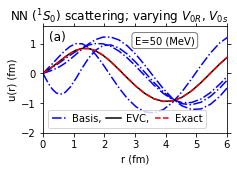

In [16]:
# for 1s0 channel
channel , dim_para = '1S0', 2 
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(3.4, 3.4*2/3), sharex=True, sharey=True) 
fig.suptitle('NN'+r' ($^1S_0$)'+' scattering; varying '+r'$V_{0R}$, $V_{0s}$'
             , x=0.5, y= 1.03,  fontsize=12)

ax.tick_params(bottom=True, top=True, left=True, right=True)
ax.set_ylabel('u(r) (fm)', fontsize=10)
ax.set_xlabel('r (fm)', fontsize=10)
ax.set_xlim([0, 6])
ax.set_ylim([-2, 1.6])
for i in range(3):
    ax.plot(rmesh, pc_array[i].scatt_wf_in_re_mesh[0], 'b-.')
ax.plot(rmesh, pc_array[3].scatt_wf_in_re_mesh[0], 'b-.', label = 'Basis,')    
ax.plot(rmesh, wf_var_mesh, 'k-', label= 'EVC,')
ax.plot(rmesh, test_pc.scatt_wf_in_re_mesh[0], 'r--', label= 'Exact')
ax.legend(loc='lower left', fontsize=10, ncol=3 , columnspacing=0.5, handlelength=1.5, handletextpad=0.5) 
ax.text(3, 1,  'E=50 (MeV)', size=10, 
          bbox=dict(boxstyle="round",  ec='black', fc=(1, 1, 1), alpha=0.5))
ax.text(0.2, 1.1,  '(a)', size=12)
fig.tight_layout()
plt.savefig(outdir+'1S0_'+'scatt_wf_4_basis_E_50MeV.pdf', bbox_inches='tight')  

#### A test of scattering phase shifts from EC <a id="test_ps"></a>
Let us plot the phase shifts associated with parameters used above

In [71]:
pc_array = [two_body_pot( local_pot_func= local_pot_func, mu=mu, hbar=hbarc, 
                         E_mesh=E_pts, r_c=r_c, r_max=r_max, r_in_mesh_pts=nr, r_out_mesh_pts=nr,
                        angL=angL, z_t=z_t, z_p= z_p)  for  local_pot_func in  local_pot_func_array]
test_pc = two_body_pot( local_pot_func= test_local_pot_func, mu=mu, hbar=hbarc, 
                         E_mesh=E_pts, r_c=r_c, r_max=r_max, r_in_mesh_pts=nr, r_out_mesh_pts=nr,
                        angL=angL, z_t=z_t, z_p= z_p) 
my_evc = EigenvectorContinuationScattering(pc_array) 
tau_var_mesh, ere_var_mesh, c_vec_mesh, lag_mesh, delta_tilde_U_condition_mesh = \
            my_evc.find_EVC_scattering(new_local_pot_func=test_local_pot_func, pinv=False, nugget=True, cond=nuggetsize)

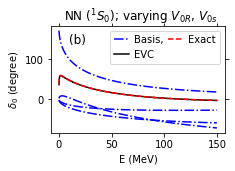

In [72]:
# for 1s0 channel
channel , dim_para = '1S0', 2 
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(3.4, 3.4*2/3), sharex=True, sharey=True) 
fig.suptitle('NN'+r' ($^1S_0$)'+'; varying '+r'$V_{0R}$, $V_{0s}$'
             , x=0.6, y= 1.03,  fontsize=12)

ax.tick_params(bottom=True, top=True, left=True, right=True)
ax.set_ylabel(r'$\delta_0$ (degree)', fontsize=10)
ax.set_xlabel('E (MeV)', fontsize=10)
#ax.set_xlim([0, 6])
#ax.set_ylim([-2, 1.6])
ax.plot(E_pts, np.arctan2(1, 1/np.tan(pc_array[2].delta_mesh)) *180/np.pi, 'b-.')
ax.plot(E_pts, pc_array[0].delta_mesh*180/np.pi, 'b-.')
ax.plot(E_pts, pc_array[1].delta_mesh*180/np.pi, 'b-.')
ax.plot(E_pts, pc_array[3].delta_mesh*180/np.pi, 'b-.', label = 'Basis,')    
ax.plot(E_pts, np.arctan(tau_var_mesh*np.sqrt(2*mu*E_pts)/hbarc)*180/np.pi, 'k-', label= 'EVC')
ax.plot(E_pts, test_pc.delta_mesh*180/np.pi, 'r--', label= 'Exact')
ax.legend(loc='upper right', fontsize=10, ncol=2 , columnspacing=0.5, handlelength=1.5, handletextpad=0.5) 
ax.text(10, 140,  '(b)', size=12)
fig.tight_layout()
plt.savefig(outdir+'1S0_'+'scatt_wf_4_basis_phase_shifts.pdf', bbox_inches='tight')  
        

#### Test EC using a sample of test points in a 2-dim parameter space  <a id="test_EC_2dim"></a>

Now let us sample a large number of test-potential points in the  $V_{0R}$ and $V_{0s}$ space, as detailed in the paper. 

In [17]:
channel

'1S0'

In [18]:
deltaV= 100 # MeV, the plus and minus range of potential-strength's variation
num_full=200 # number of test-potential points
dim_para=2 # dim of the parameter space 
nuggetsize=1.e-10
np.random.seed(8209)

test_potpara_list=np.apply_along_axis(lambda v : np.array( [ V0_R_Minn + (v[0] - 0.5)*2*deltaV  , 
                                                              V0_s_Minn + (v[1] - 0.5) * 2*deltaV ] ) , 
                            1,  np.random.rand(num_full, dim_para))  
num_basis_list= np.arange(3,10)
np.random.seed(754)
basis_potpara_array_list= [np.apply_along_axis(lambda v : np.array( [ V0_R_Minn + (v[0]-0.5)*2*deltaV, 
                                                                    V0_s_Minn + (v[1] - 0.5) * 2*deltaV  ] ) , 
                            1, lhs(dim_para,num_basis))  for num_basis in num_basis_list]
local_pot_func= lambda r, potpara_vec : local_pot_NN_Minn(r, channel=channel, V0_R=potpara_vec[0], V0_s=potpara_vec[1])
nonlocal_pot_func= lambda rvec, potpara_vec: 0 

In [19]:
test_pc_list_1s0_2dim = collect_results(outdir=outdir, channel=channel, nuggetsize=nuggetsize, num_basis_list=num_basis_list, 
                     basis_potpara_array_list=basis_potpara_array_list, test_potpara_list=test_potpara_list, 
                    local_pot_func= local_pot_func, nonlocal_pot_func=nonlocal_pot_func) 

setting up test potential class list: (0, 200)
setting up test potential class list: (10, 200)
setting up test potential class list: (20, 200)
setting up test potential class list: (30, 200)
setting up test potential class list: (40, 200)
setting up test potential class list: (50, 200)
setting up test potential class list: (60, 200)
setting up test potential class list: (70, 200)
setting up test potential class list: (80, 200)
setting up test potential class list: (90, 200)
setting up test potential class list: (100, 200)
setting up test potential class list: (110, 200)
setting up test potential class list: (120, 200)
setting up test potential class list: (130, 200)
setting up test potential class list: (140, 200)
setting up test potential class list: (150, 200)
setting up test potential class list: (160, 200)
setting up test potential class list: (170, 200)
setting up test potential class list: (180, 200)
setting up test potential class list: (190, 200)
looping over basis array: 3
loo

#### Save the results. Most of the calculation output have been stored in the .pkl file, even including the condition number for $\Delta\tilde{U}$ matrix and lagrange multiplier. See the keys of the res_dict

In [95]:
### save the results to a file
with open(outdir+'res_dict.pkl', 'wb') as output:
    pickle.dump(res_dict, output, pickle.HIGHEST_PROTOCOL)

#### Test EC using a sample of test points in a 4-dim parameter space <a id="test_EC_4dim"></a>

Vary $V_{0R}$, $V_{0s}$, $\kappa_R$ , $\kappa_s$ 

In [110]:
deltaV= 100 # MeV, the plus and minus range of potential-strength's variation
deltawidth_relative=0.5
num_full=1000 # number of test-potential points
dim_para=4 # dim of the parameter space 
nuggetsize=1.e-10
np.random.seed(98734)

test_potpara_list=np.apply_along_axis(lambda v : np.array( [ V0_R_Minn + (v[0] - 0.5)*2*deltaV  , 
                                                              V0_s_Minn + (v[1] - 0.5) * 2*deltaV , 
                                                              kappa_R_Minn*( 1 + (v[2] - 0.5)/0.5*deltawidth_relative),
                                                            kappa_s_Minn*( 1 + (v[3] - 0.5)/0.5*deltawidth_relative)] ) , 
                            1,  np.random.rand(num_full, dim_para))   
num_basis_list= np.arange(dim_para+1,15)
np.random.seed(98687)
basis_potpara_array_list= [np.apply_along_axis(lambda v : np.array( [ V0_R_Minn + (v[0] - 0.5)*2*deltaV  , 
                                                              V0_s_Minn + (v[1] - 0.5) * 2*deltaV , 
                                                              kappa_R_Minn*( 1 + (v[2] - 0.5)/0.5*deltawidth_relative),
                                                            kappa_s_Minn*( 1 + (v[3] - 0.5)/0.5*deltawidth_relative)] ) , 
                            1,  lhs(dim_para,num_basis))  for num_basis in num_basis_list]

local_pot_func= lambda r, potpara_vec : local_pot_NN_Minn(r, channel=channel, V0_R=potpara_vec[0], V0_s=potpara_vec[1], 
                                                          kappa_R=potpara_vec[2], kappa_s=potpara_vec[3])
nonlocal_pot_func= lambda rvec, potpara_vec: 0 

In [111]:
test_pc_list_1s0_4dim = collect_results(outdir=outdir, channel=channel, nuggetsize=nuggetsize, num_basis_list=num_basis_list, 
                     basis_potpara_array_list=basis_potpara_array_list, test_potpara_list=test_potpara_list, 
                    local_pot_func= local_pot_func, nonlocal_pot_func=nonlocal_pot_func) 

setting up test potential class list: (0, 1000)
setting up test potential class list: (10, 1000)
setting up test potential class list: (20, 1000)
setting up test potential class list: (30, 1000)
setting up test potential class list: (40, 1000)
setting up test potential class list: (50, 1000)
setting up test potential class list: (60, 1000)
setting up test potential class list: (70, 1000)
setting up test potential class list: (80, 1000)
setting up test potential class list: (90, 1000)
setting up test potential class list: (100, 1000)
setting up test potential class list: (110, 1000)
setting up test potential class list: (120, 1000)
setting up test potential class list: (130, 1000)
setting up test potential class list: (140, 1000)
setting up test potential class list: (150, 1000)
setting up test potential class list: (160, 1000)
setting up test potential class list: (170, 1000)
setting up test potential class list: (180, 1000)
setting up test potential class list: (190, 1000)
setting up 

In [112]:
### save the results to a file
with open(outdir+'res_dict.pkl', 'wb') as output:
    pickle.dump(res_dict, output, pickle.HIGHEST_PROTOCOL)

### for 3S1 channel <a id="3S1_channel"></a>

In [115]:
channel='3S1'

#### Test EC in a 2-dim parameter space <a id="test_EC_2dim_3S1"></a>

Now let us sample a large number of test-potential points in the  $V_{0R}$ and $V_{0t}$ space, as detailed in the paper. 

In [117]:
channel

'3S1'

In [121]:
deltaV= 100 # MeV, the plus and minus range of potential-strength's variation
num_full=200 # number of test-potential points
dim_para=2 # dim of the parameter space 
nuggetsize=1.e-9
np.random.seed(3049)

test_potpara_list=np.apply_along_axis(lambda v : np.array( [ V0_R_Minn + (v[0] - 0.5)*2*deltaV  , 
                                                              V0_t_Minn + (v[1] - 0.5) * 2*deltaV ] ) , 
                            1,  np.random.rand(num_full, dim_para))  
num_basis_list= np.arange(3,10)
basis_potpara_array_list= [np.apply_along_axis(lambda v : np.array( [ V0_R_Minn + (v[0]-0.5)*2*deltaV, 
                                                                    V0_t_Minn + (v[1] - 0.5) * 2*deltaV  ] ) , 
                            1, lhs(dim_para,num_basis))  for num_basis in num_basis_list]
local_pot_func= lambda r, potpara_vec : local_pot_NN_Minn(r, channel=channel, V0_R=potpara_vec[0], V0_t=potpara_vec[1])
nonlocal_pot_func= lambda rvec, potpara_vec: 0 

In [122]:
test_pc_list_3s1_2dim = collect_results(outdir=outdir, channel=channel, nuggetsize=nuggetsize, num_basis_list=num_basis_list, 
                     basis_potpara_array_list=basis_potpara_array_list, test_potpara_list=test_potpara_list, 
                    local_pot_func= local_pot_func, nonlocal_pot_func=nonlocal_pot_func) 

setting up test potential class list: (0, 200)
setting up test potential class list: (10, 200)
setting up test potential class list: (20, 200)
setting up test potential class list: (30, 200)
setting up test potential class list: (40, 200)
setting up test potential class list: (50, 200)
setting up test potential class list: (60, 200)
setting up test potential class list: (70, 200)
setting up test potential class list: (80, 200)
setting up test potential class list: (90, 200)
setting up test potential class list: (100, 200)
setting up test potential class list: (110, 200)
setting up test potential class list: (120, 200)
setting up test potential class list: (130, 200)
setting up test potential class list: (140, 200)
setting up test potential class list: (150, 200)
setting up test potential class list: (160, 200)
setting up test potential class list: (170, 200)
setting up test potential class list: (180, 200)
setting up test potential class list: (190, 200)
looping over basis array: 3
loo

In [123]:
### save the results to a file
with open(outdir+'res_dict.pkl', 'wb') as output:
    pickle.dump(res_dict, output, pickle.HIGHEST_PROTOCOL)

#### Test EC in a 4-dim parameter space <a id="test_EC_4dim_3S1"></a>

Now let us scan the 4-dim space in $V_{0R}$, $V_{0t}$, $\kappa_R$ , $\kappa_t$ 

In [125]:
deltaV= 100 # MeV, the plus and minus range of potential-strength's variation
deltawidth_relative=0.5
num_full=1000 # number of test-potential points
dim_para=4 # dim of the parameter space 
nuggetsize=1.e-9
np.random.seed(997)

test_potpara_list=np.apply_along_axis(lambda v : np.array( [ V0_R_Minn + (v[0] - 0.5)*2*deltaV  , 
                                                              V0_t_Minn + (v[1] - 0.5) * 2*deltaV , 
                                                              kappa_R_Minn*( 1 + (v[2] - 0.5)/0.5*deltawidth_relative),
                                                            kappa_t_Minn*( 1 + (v[3] - 0.5)/0.5*deltawidth_relative)] ) , 
                            1,  np.random.rand(num_full, dim_para))   
num_basis_list= np.arange(dim_para+1,15)
np.random.seed(9862)
basis_potpara_array_list= [np.apply_along_axis(lambda v : np.array( [ V0_R_Minn + (v[0] - 0.5)*2*deltaV  , 
                                                              V0_t_Minn + (v[1] - 0.5) * 2*deltaV , 
                                                              kappa_R_Minn*( 1 + (v[2] - 0.5)/0.5*deltawidth_relative),
                                                            kappa_t_Minn*( 1 + (v[3] - 0.5)/0.5*deltawidth_relative)] ) , 
                            1,  lhs(dim_para,num_basis))  for num_basis in num_basis_list]

local_pot_func= lambda r, potpara_vec : local_pot_NN_Minn(r, channel=channel, V0_R=potpara_vec[0], V0_t=potpara_vec[1], 
                                                          kappa_R=potpara_vec[2], kappa_t=potpara_vec[3])
nonlocal_pot_func= lambda rvec, potpara_vec: 0 

In [126]:
test_pc_list_3s1_4dim = collect_results(outdir=outdir, channel=channel, nuggetsize=nuggetsize, num_basis_list=num_basis_list, 
                     basis_potpara_array_list=basis_potpara_array_list, test_potpara_list=test_potpara_list, 
                    local_pot_func= local_pot_func, nonlocal_pot_func=nonlocal_pot_func) 

setting up test potential class list: (0, 1000)
setting up test potential class list: (10, 1000)
setting up test potential class list: (20, 1000)
setting up test potential class list: (30, 1000)
setting up test potential class list: (40, 1000)
setting up test potential class list: (50, 1000)
setting up test potential class list: (60, 1000)
setting up test potential class list: (70, 1000)
setting up test potential class list: (80, 1000)
setting up test potential class list: (90, 1000)
setting up test potential class list: (100, 1000)
setting up test potential class list: (110, 1000)
setting up test potential class list: (120, 1000)
setting up test potential class list: (130, 1000)
setting up test potential class list: (140, 1000)
setting up test potential class list: (150, 1000)
setting up test potential class list: (160, 1000)
setting up test potential class list: (170, 1000)
setting up test potential class list: (180, 1000)
setting up test potential class list: (190, 1000)
setting up 

In [127]:
### save the results to a file
with open(outdir+'res_dict.pkl', 'wb') as output:
    pickle.dump(res_dict, output, pickle.HIGHEST_PROTOCOL)

## Collect the results and make plots for both channels <a id="plots"></a>


In [128]:
with open(outdir+'res_dict.pkl', 'rb') as output:
    res_dict=pickle.load(output)

### For 1S0 channel <a id="plots_1S0"></a>

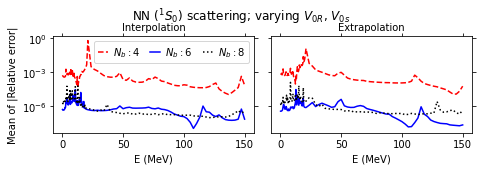

In [129]:
# for 1s0 channel in 2-dim space
channel , dim_para,  num_full = '1S0', 2, 200 
color_list= ['red', 'blue', 'black']  
linestyle_list= ['--', '-', ':']
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(3.4*2, 3.4 *2/3), sharex=False, sharey=True) 
fig.suptitle('NN'+r' ($^1S_0$)'+' scattering; varying '+r'$V_{0R}$, $V_{0s}$' , x=0.5, y= 1.03,  fontsize=12)

ax[0].set_yscale('log')
ax[0].tick_params(bottom=True, top=True, left=True, right=True)
ax[0].set_title('Interpolation', fontsize= 10)
ax[0].set_ylabel('Mean of |Relative error|', fontsize=10)
ax[1].set_yscale('log')
ax[1].tick_params(bottom=True, top=True, left=True, right=True)
ax[1].set_title('Extrapolation', fontsize= 10)
ax[0].set_xlabel('E (MeV)', fontsize=10)
ax[1].set_xlabel('E (MeV)', fontsize=10)
########### with num_basis = [4, 6, 8] 
for i, num_basis  in enumerate([4,6,8]) :  
    output_file_prefix=outdir + channel + '_para-dim-' + f'{dim_para}' \
    + '_basis-' + f'{num_basis}'+'_full-sample-' + f'{num_full}' + '_'
    test_pc_list_ere_mesh_list, testinouthaull, ere_var_mesh_list  = \
                        map(res_dict[output_file_prefix].get, [ 'test_pc_list_ere_mesh_list', 'testinouthaull', 'ere_var_mesh_list'] )   
    ere_mesh_list_1 = test_pc_list_ere_mesh_list[testinouthaull]
    ere_mesh_list_2 = test_pc_list_ere_mesh_list[np.logical_not(testinouthaull)]
    ere_var_mesh_list_1=ere_var_mesh_list[testinouthaull]
    ere_var_mesh_list_2=ere_var_mesh_list[np.logical_not(testinouthaull)]    
    ax[0].plot(E_pts, np.mean( np.array( [ np.absolute(ere_mesh[1]/ere_var_mesh_list_1[i]-1) 
                    for i, ere_mesh in enumerate(ere_mesh_list_1) ]) , axis=0 ), label = r"$N_b:$"+f'{num_basis}', 
               color=color_list[i], linestyle=linestyle_list[i])
    ax[1].plot(E_pts, np.mean( np.array( [ np.absolute(ere_mesh[1]/ere_var_mesh_list_2[i]-1) 
                    for i, ere_mesh in enumerate(ere_mesh_list_2) ]) , axis=0 ), label = r"$N_b:$"+f'{num_basis}',
              color=color_list[i], linestyle=linestyle_list[i])
ax[0].legend(loc='best', fontsize=10, ncol=3 , columnspacing=1, handlelength=1, handletextpad=0.5) 
#ax[1].legend(loc='best', fontsize=10, ncol=3 , columnspacing=1, handlelength=1, handletextpad=0.5) 
fig.tight_layout()
plt.savefig(outdir+'1S0_'+'interpolation_vs_extrapolation_rel_error_paper.pdf', bbox_inches='tight')  
    

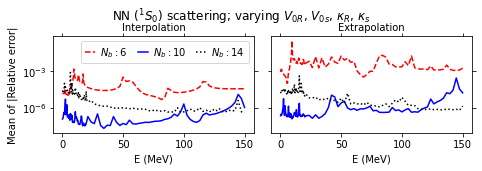

In [130]:
# for 1s0 channel in 4-dim space
channel , dim_para,  num_full = '1S0', 4, 1000 
color_list= ['red', 'blue', 'black']  
linestyle_list= ['--', '-', ':']
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(3.4*2, 3.4*2/3), sharex=True, sharey=True) 
fig.suptitle('NN'+r' ($^1S_0$)'+' scattering; varying '+r'$V_{0R}$, $V_{0s}$, $\kappa_R$, $\kappa_s$'
             , x=0.5, y= 1.03,  fontsize=12)

ax[0].set_yscale('log')
ax[0].tick_params(bottom=True, top=True, left=True, right=True)
ax[0].set_title('Interpolation', fontsize= 10)
ax[0].set_ylabel('Mean of |Relative error|', fontsize=10)
ax[1].set_yscale('log')
ax[1].tick_params(bottom=True, top=True, left=True, right=True)
ax[1].set_title('Extrapolation', fontsize= 10)
ax[0].set_xlabel('E (MeV)', fontsize=10)
ax[1].set_xlabel('E (MeV)', fontsize=10)
########### with num_basis = [6, 10, 14] 
for i, num_basis  in enumerate([6, 10, 14]) :  
    output_file_prefix=outdir + channel + '_para-dim-' + f'{dim_para}' \
    + '_basis-' + f'{num_basis}'+'_full-sample-' + f'{num_full}' + '_'
    test_pc_list_ere_mesh_list, testinouthaull, ere_var_mesh_list  = \
                        map(res_dict[output_file_prefix].get, [ 'test_pc_list_ere_mesh_list', 'testinouthaull', 'ere_var_mesh_list'] )   
    ere_mesh_list_1 = test_pc_list_ere_mesh_list[testinouthaull]
    ere_mesh_list_2 = test_pc_list_ere_mesh_list[np.logical_not(testinouthaull)]
    ere_var_mesh_list_1=ere_var_mesh_list[testinouthaull]
    ere_var_mesh_list_2=ere_var_mesh_list[np.logical_not(testinouthaull)]    
    ax[0].plot(E_pts, np.mean( np.array( [ np.absolute(ere_mesh[1]/ere_var_mesh_list_1[i]-1) 
                    for i, ere_mesh in enumerate(ere_mesh_list_1) ]) , axis=0 ), label = r"$N_b:$"+f'{num_basis}',
              color=color_list[i], linestyle=linestyle_list[i])
    ax[1].plot(E_pts, np.mean( np.array( [ np.absolute(ere_mesh[1]/ere_var_mesh_list_2[i]-1) 
                    for i, ere_mesh in enumerate(ere_mesh_list_2) ]) , axis=0 ), label = r"$N_b:$"+f'{num_basis}', 
              color=color_list[i], linestyle=linestyle_list[i])
ax[0].legend(loc='best', fontsize=10, ncol=3 , columnspacing=1, handlelength=1, handletextpad=0.5) 
#ax[1].legend(loc='best', fontsize=10, ncol=3 , columnspacing=1, handlelength=1, handletextpad=0.5) 
fig.tight_layout()
plt.savefig(outdir+'1S0_'+'interpolation_vs_extrapolation_rel_error_4dim_paper.pdf', bbox_inches='tight')  
    

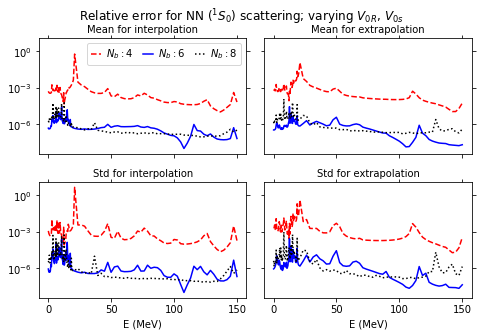

In [131]:
# for 1s0 channel in 2-dim space with more results
channel , dim_para,  num_full = '1S0', 2, 200 
color_list= ['red', 'blue', 'black']  
linestyle_list= ['--', '-', ':']
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(3.4*2, 3.4*2*2/3), sharex=True, sharey=True) 
fig.suptitle('Relative error for NN'+r' ($^1S_0$)'+' scattering; varying '+r'$V_{0R}$, $V_{0s}$' , x=0.5, y= 1.02,  fontsize=12)


ax[0,0].set_yscale('log')
ax[0,0].tick_params(bottom=True, top=True, left=True, right=True)
ax[0,0].set_title('Mean for interpolation', fontsize= 10)
ax[0,1].set_yscale('log')
ax[0,1].tick_params(bottom=True, top=True, left=True, right=True)
ax[0,1].set_title('Mean for extrapolation', fontsize= 10)
ax[1,0].set_yscale('log')
ax[1,0].set_xlabel('E (MeV)', fontsize=10)
ax[1,0].tick_params(bottom=True, top=True, left=True, right=True)
ax[1,0].set_title('Std for interpolation', fontsize= 10)
ax[1,1].set_yscale('log')
ax[1,1].set_xlabel('E (MeV)', fontsize=10)
ax[1,1].tick_params(bottom=True, top=True, left=True, right=True)
ax[1,1].set_title('Std for extrapolation', fontsize= 10)
########### with num_basis = [4, 6, 8] 
for i, num_basis  in enumerate([4,6,8]) :  
    output_file_prefix=outdir + channel + '_para-dim-' + f'{dim_para}' \
    + '_basis-' + f'{num_basis}'+'_full-sample-' + f'{num_full}' + '_'
    test_pc_list_ere_mesh_list, testinouthaull, ere_var_mesh_list  = \
                        map(res_dict[output_file_prefix].get, [ 'test_pc_list_ere_mesh_list', 'testinouthaull', 'ere_var_mesh_list'] )   
    ere_mesh_list_1 = test_pc_list_ere_mesh_list[testinouthaull]
    ere_mesh_list_2 = test_pc_list_ere_mesh_list[np.logical_not(testinouthaull)]
    ere_var_mesh_list_1=ere_var_mesh_list[testinouthaull]
    ere_var_mesh_list_2=ere_var_mesh_list[np.logical_not(testinouthaull)]    
    ax[0,0].plot(E_pts, np.mean( np.array( [ np.absolute(ere_mesh[1]/ere_var_mesh_list_1[i]-1) 
                    for i, ere_mesh in enumerate(ere_mesh_list_1) ]) , axis=0 ), label = r"$N_b:$"+f'{num_basis}', 
                 color=color_list[i], linestyle=linestyle_list[i])
    ax[0,1].plot(E_pts, np.mean( np.array( [ np.absolute(ere_mesh[1]/ere_var_mesh_list_2[i]-1) 
                    for i, ere_mesh in enumerate(ere_mesh_list_2) ]) , axis=0 ), label = r"$N_b:$"+f'{num_basis}',
                 color=color_list[i], linestyle=linestyle_list[i])
    ax[1,0].plot(E_pts, np.std(np.array( [ np.absolute(ere_mesh[1]/ere_var_mesh_list_1[i]-1) 
                    for i, ere_mesh in enumerate(ere_mesh_list_1) ]) , axis=0 ),  label = r"$N_b:$"+f'{num_basis}',
                 color=color_list[i], linestyle=linestyle_list[i])
    ax[1,1].plot(E_pts, np.std(np.array( [ np.absolute(ere_mesh[1]/ere_var_mesh_list_2[i]-1) 
                    for i, ere_mesh in enumerate(ere_mesh_list_2) ]) , axis=0 ),  label = r"$N_b:$"+f'{num_basis}' , 
                 color=color_list[i], linestyle=linestyle_list[i])
ax[0,0].legend(loc='best', fontsize=10, ncol=3 , columnspacing=1, handlelength=1, handletextpad=0.5) 
#ax[0,1].legend(loc='best', fontsize=10, ncol=3 , columnspacing=1, handlelength=1, handletextpad=0.5) 
#ax[1,0].legend(loc='best', fontsize=10, ncol=3 , columnspacing=1, handlelength=1, handletextpad=0.5) 
#ax[1,1].legend(loc='best', fontsize=10, ncol=3 , columnspacing=1, handlelength=1, handletextpad=0.5) 
fig.tight_layout()
plt.savefig(outdir+'1S0_'+'interpolation_vs_extrapolation_rel_error.pdf', bbox_inches='tight')  
    

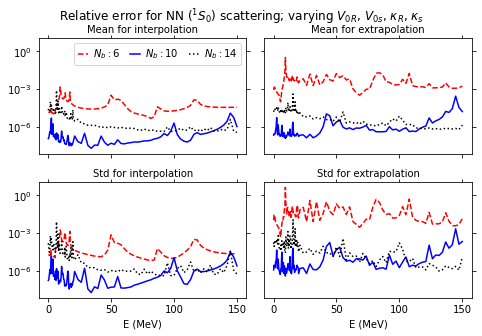

In [133]:
# for 1s0 channel in 4-dim with more results
channel , dim_para,  num_full = '1S0', 4, 1000 
color_list= ['red', 'blue', 'black']  
linestyle_list= ['--', '-', ':']
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(3.4*2, 3.4*2*2/3), sharex=True, sharey=True) 
fig.suptitle('Relative error for NN'+r' ($^1S_0$)'+' scattering; varying '+r'$V_{0R}$, $V_{0s}$, $\kappa_R$, $\kappa_s$'
             , x=0.5, y= 1.02,  fontsize=12)

ax[0,0].set_yscale('log')
ax[0,0].tick_params(bottom=True, top=True, left=True, right=True)
ax[0,0].set_title('Mean for interpolation', fontsize= 10)
ax[0,1].set_yscale('log')
ax[0,1].tick_params(bottom=True, top=True, left=True, right=True)
ax[0,1].set_title('Mean for extrapolation', fontsize= 10)
ax[1,0].set_yscale('log')
ax[1,0].set_xlabel('E (MeV)', fontsize=10)
ax[1,0].tick_params(bottom=True, top=True, left=True, right=True)
ax[1,0].set_title('Std for interpolation', fontsize= 10)
ax[1,1].set_yscale('log')
ax[1,1].set_xlabel('E (MeV)', fontsize=10)
ax[1,1].tick_params(bottom=True, top=True, left=True, right=True)
ax[1,1].set_title('Std for extrapolation', fontsize= 10)
########### with num_basis = [6, 9, 12] 
for i, num_basis  in enumerate([6, 10, 14]) :  
    output_file_prefix=outdir + channel + '_para-dim-' + f'{dim_para}' \
    + '_basis-' + f'{num_basis}'+'_full-sample-' + f'{num_full}' + '_'
    test_pc_list_ere_mesh_list, testinouthaull, ere_var_mesh_list  = \
                        map(res_dict[output_file_prefix].get, ['test_pc_list_ere_mesh_list', 'testinouthaull', 'ere_var_mesh_list'] )   
    ere_mesh_list_1 = test_pc_list_ere_mesh_list[testinouthaull]
    ere_mesh_list_2 = test_pc_list_ere_mesh_list[np.logical_not(testinouthaull)]
    ere_var_mesh_list_1=ere_var_mesh_list[testinouthaull]
    ere_var_mesh_list_2=ere_var_mesh_list[np.logical_not(testinouthaull)]    
    ax[0,0].plot(E_pts, np.mean( np.array( [ np.absolute(ere_mesh[1]/ere_var_mesh_list_1[i]-1) 
                    for i, ere_mesh in enumerate(ere_mesh_list_1) ]) , axis=0 ), label = r"$N_b:$"+f'{num_basis}',
                 color=color_list[i], linestyle=linestyle_list[i])
    ax[0,1].plot(E_pts, np.mean( np.array( [ np.absolute(ere_mesh[1]/ere_var_mesh_list_2[i]-1) 
                    for i, ere_mesh in enumerate(ere_mesh_list_2) ]) , axis=0 ), label = r"$N_b:$"+f'{num_basis}',
                 color=color_list[i], linestyle=linestyle_list[i])
    ax[1,0].plot(E_pts, np.std(np.array( [ np.absolute(ere_mesh[1]/ere_var_mesh_list_1[i]-1) 
                    for i, ere_mesh in enumerate(ere_mesh_list_1) ]) , axis=0 ),  label = r"$N_b:$"+f'{num_basis}' ,
                 color=color_list[i], linestyle=linestyle_list[i])
    ax[1,1].plot(E_pts, np.std(np.array( [ np.absolute(ere_mesh[1]/ere_var_mesh_list_2[i]-1) 
                    for i, ere_mesh in enumerate(ere_mesh_list_2) ]) , axis=0 ),  label = r"$N_b:$"+f'{num_basis}',
                 color=color_list[i], linestyle=linestyle_list[i])
ax[0,0].legend(loc='best', fontsize=10, ncol=3 , columnspacing=1, handlelength=1, handletextpad=0.5) 
#ax[0,1].legend(loc='best', fontsize=10, ncol=3 , columnspacing=1, handlelength=1, handletextpad=0.5) 
#ax[1,0].legend(loc='best', fontsize=10, ncol=3 , columnspacing=1, handlelength=1, handletextpad=0.5) 
#ax[1,1].legend(loc='best', fontsize=10, ncol=3 , columnspacing=1, handlelength=1, handletextpad=0.5) 
fig.tight_layout()
plt.savefig(outdir+'1S0_'+'interpolation_vs_extrapolation_rel_error_4dim.pdf', bbox_inches='tight')  
    

### For 3S1 channel <a id="plots_3S1"></a>

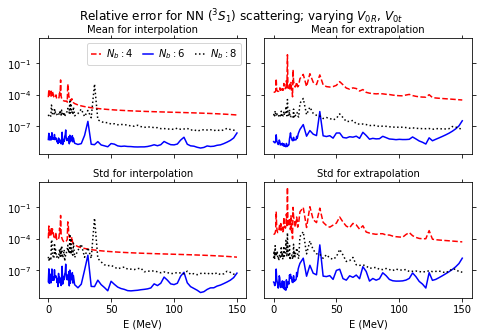

In [132]:
# for 3S1 channel in 2-dim space
channel , dim_para,  num_full = '3S1', 2, 200 
color_list= ['red', 'blue', 'black']  
linestyle_list= ['--', '-', ':']
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(3.4*2, 3.4*2*2/3), sharex=True, sharey=True) 
fig.suptitle('Relative error for NN'+r' ($^3S_1$)'+' scattering; varying '+r'$V_{0R}$, $V_{0t}$' , x=0.5, y= 1.02,  fontsize=12)

ax[0,0].set_yscale('log')
ax[0,0].tick_params(bottom=True, top=True, left=True, right=True)
ax[0,0].set_title('Mean for interpolation', fontsize= 10)
ax[0,1].set_yscale('log')
ax[0,1].tick_params(bottom=True, top=True, left=True, right=True)
ax[0,1].set_title('Mean for extrapolation', fontsize= 10)
ax[1,0].set_yscale('log')
ax[1,0].set_xlabel('E (MeV)', fontsize=10)
ax[1,0].tick_params(bottom=True, top=True, left=True, right=True)
ax[1,0].set_title('Std for interpolation', fontsize= 10)
ax[1,1].set_yscale('log')
ax[1,1].set_xlabel('E (MeV)', fontsize=10)
ax[1,1].tick_params(bottom=True, top=True, left=True, right=True)
ax[1,1].set_title('Std for extrapolation', fontsize= 10)
########### with num_basis = [4, 6, 8] 
for i, num_basis  in enumerate([4,6,8]) :  
    output_file_prefix=outdir + channel + '_para-dim-' + f'{dim_para}' \
    + '_basis-' + f'{num_basis}'+'_full-sample-' + f'{num_full}' + '_'
    test_pc_list_ere_mesh_list, testinouthaull, ere_var_mesh_list  = \
                        map(res_dict[output_file_prefix].get, [ 'test_pc_list_ere_mesh_list', 'testinouthaull', 'ere_var_mesh_list'] )   
    ere_mesh_list_1 = test_pc_list_ere_mesh_list[testinouthaull]
    ere_mesh_list_2 = test_pc_list_ere_mesh_list[np.logical_not(testinouthaull)]
    ere_var_mesh_list_1=ere_var_mesh_list[testinouthaull]
    ere_var_mesh_list_2=ere_var_mesh_list[np.logical_not(testinouthaull)]    
    ax[0,0].plot(E_pts, np.mean( np.array( [ np.absolute(ere_mesh[1]/ere_var_mesh_list_1[i]-1) 
                    for i, ere_mesh in enumerate(ere_mesh_list_1) ]) , axis=0 ), label = r"$N_b:$"+f'{num_basis}',
                 color=color_list[i], linestyle=linestyle_list[i])
    ax[0,1].plot(E_pts, np.mean( np.array( [ np.absolute(ere_mesh[1]/ere_var_mesh_list_2[i]-1) 
                    for i, ere_mesh in enumerate(ere_mesh_list_2) ]) , axis=0 ), label = r"$N_b:$"+f'{num_basis}', 
                 color=color_list[i], linestyle=linestyle_list[i])
    ax[1,0].plot(E_pts, np.std(np.array( [ np.absolute(ere_mesh[1]/ere_var_mesh_list_1[i]-1) 
                    for i, ere_mesh in enumerate(ere_mesh_list_1) ]) , axis=0 ),  label = r"$N_b:$"+f'{num_basis}',
                 color=color_list[i], linestyle=linestyle_list[i])
    ax[1,1].plot(E_pts, np.std(np.array( [ np.absolute(ere_mesh[1]/ere_var_mesh_list_2[i]-1) 
                    for i, ere_mesh in enumerate(ere_mesh_list_2) ]) , axis=0 ),  label = r"$N_b:$"+f'{num_basis}', 
                 color=color_list[i], linestyle=linestyle_list[i])

#ax[0,0].legend(fontsize=10)
ax[0,0].legend(loc='best', fontsize=10, ncol=3 , columnspacing=1, handlelength=1, handletextpad=0.5) 
#ax[0,1].legend(loc='best', fontsize=10, ncol=3 , columnspacing=1, handlelength=1, handletextpad=0.5) 
#ax[1,0].legend(loc='best', fontsize=10, ncol=3 , columnspacing=1, handlelength=1, handletextpad=0.5) 
#ax[1,1].legend(loc='best', fontsize=10, ncol=3 , columnspacing=1, handlelength=1, handletextpad=0.5) 
fig.tight_layout()
plt.savefig(outdir+'3S1_'+'interpolation_vs_extrapolation_rel_error.pdf', bbox_inches='tight')  
    

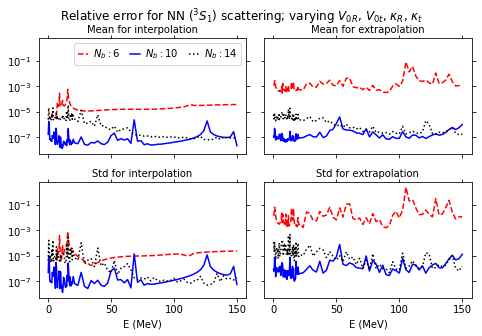

In [134]:
# for 3S1 channel in 4-dim space
channel , dim_para,  num_full = '3S1', 4, 1000 
color_list= ['red', 'blue', 'black']  
linestyle_list= ['--', '-', ':']
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(3.4*2, 3.4*2*2/3), sharex=True, sharey=True) 
fig.suptitle('Relative error for NN'+r' ($^3S_1$)'+' scattering; varying '+r'$V_{0R}$, $V_{0t}$, $\kappa_R$, $\kappa_t$' 
             , x=0.5, y= 1.02,  fontsize=12)

ax[0,0].set_yscale('log')
ax[0,0].tick_params(bottom=True, top=True, left=True, right=True)
ax[0,0].set_title('Mean for interpolation', fontsize= 10)
ax[0,1].set_yscale('log')
ax[0,1].tick_params(bottom=True, top=True, left=True, right=True)
ax[0,1].set_title('Mean for extrapolation', fontsize= 10)
ax[1,0].set_yscale('log')
ax[1,0].set_xlabel('E (MeV)', fontsize=10)
ax[1,0].tick_params(bottom=True, top=True, left=True, right=True)
ax[1,0].set_title('Std for interpolation', fontsize= 10)
ax[1,1].set_yscale('log')
ax[1,1].set_xlabel('E (MeV)', fontsize=10)
ax[1,1].tick_params(bottom=True, top=True, left=True, right=True)
ax[1,1].set_title('Std for extrapolation', fontsize= 10)
########### with num_basis = [6, 9, 12] 
for i, num_basis  in enumerate([6, 10, 14]) :  
    output_file_prefix=outdir + channel + '_para-dim-' + f'{dim_para}' \
    + '_basis-' + f'{num_basis}'+'_full-sample-' + f'{num_full}' + '_'
    test_pc_list_ere_mesh_list, testinouthaull, ere_var_mesh_list  = \
                        map(res_dict[output_file_prefix].get, [ 'test_pc_list_ere_mesh_list', 'testinouthaull', 'ere_var_mesh_list'] )   
    ere_mesh_list_1 = test_pc_list_ere_mesh_list[testinouthaull]
    ere_mesh_list_2 = test_pc_list_ere_mesh_list[np.logical_not(testinouthaull)]
    ere_var_mesh_list_1=ere_var_mesh_list[testinouthaull]
    ere_var_mesh_list_2=ere_var_mesh_list[np.logical_not(testinouthaull)]    
    ax[0,0].plot(E_pts, np.mean( np.array( [ np.absolute(ere_mesh[1]/ere_var_mesh_list_1[i]-1) 
                    for i, ere_mesh in enumerate(ere_mesh_list_1) ]) , axis=0 ), label = r"$N_b:$"+f'{num_basis}',
                 color=color_list[i], linestyle=linestyle_list[i])
    ax[0,1].plot(E_pts, np.mean( np.array( [ np.absolute(ere_mesh[1]/ere_var_mesh_list_2[i]-1) 
                    for i, ere_mesh in enumerate(ere_mesh_list_2) ]) , axis=0 ), label = r"$N_b:$"+f'{num_basis}',
                 color=color_list[i], linestyle=linestyle_list[i])
    ax[1,0].plot(E_pts, np.std(np.array( [ np.absolute(ere_mesh[1]/ere_var_mesh_list_1[i]-1) 
                    for i, ere_mesh in enumerate(ere_mesh_list_1) ]) , axis=0 ),  label = r"$N_b:$"+f'{num_basis}' ,
                 color=color_list[i], linestyle=linestyle_list[i])
    ax[1,1].plot(E_pts, np.std(np.array( [ np.absolute(ere_mesh[1]/ere_var_mesh_list_2[i]-1) 
                    for i, ere_mesh in enumerate(ere_mesh_list_2) ]) , axis=0 ),  label = r"$N_b:$"+f'{num_basis}' ,
                 color=color_list[i], linestyle=linestyle_list[i])

#ax[0,0].legend(fontsize=10)
ax[0,0].legend(loc='best', fontsize=10, ncol=3 , columnspacing=1, handlelength=1, handletextpad=0.5) 
#ax[0,1].legend(loc='best', fontsize=10, ncol=3 , columnspacing=1, handlelength=1, handletextpad=0.5) 
#ax[1,0].legend(loc='best', fontsize=10, ncol=3 , columnspacing=1, handlelength=1, handletextpad=0.5) 
#ax[1,1].legend(loc='best', fontsize=10, ncol=3 , columnspacing=1, handlelength=1, handletextpad=0.5) 
fig.tight_layout()
plt.savefig(outdir+'3S1_'+'interpolation_vs_extrapolation_rel_error_4dim.pdf', bbox_inches='tight')  
    